In [40]:
import seaborn
from matplotlib import pyplot as plt
from torch.nn import Module
from torch.nn.modules.transformer import TransformerEncoder

from src.data.processing import load_texts, remove_stress_marks, remove_character_before_stress_marks
from src.model.inference import Inference
from src.paths import DATA_DIR, RUNS_DIR


def enable_attention_outputs(attention: Module) -> None:
    forward_method = attention.forward

    def wrap(*args, **kwargs):
        kwargs["need_weights"] = True
        kwargs["average_attn_weights"] = False

        return forward_method(*args, **kwargs)

    attention.forward = wrap


class OutputBuffer:
    def __init__(self):
        self.outputs = []

    def __call__(self, module_, module_input, module_output):
        self.outputs.append(module_output[1].squeeze(0))

    def clear(self):
        self.outputs = []

In [41]:
model_dir = RUNS_DIR / "v2.1"
inference = Inference(model_dir, weights_filename="weights_best.pth")

# Choose module for analysis: encoder/decoder
module = inference.model.transformer.decoder

# Choose attention for analysis: self_attn/multihead_attn
# Encoder only has self attention
attention_type = "multihead_attn"
output_buffers = [OutputBuffer() for _ in module.layers]

for i, layer in enumerate(module.layers):
    layer_attention = getattr(layer, attention_type)
    enable_attention_outputs(layer_attention)
    layer_attention.register_forward_hook(output_buffers[i])

In [42]:
texts = load_texts(DATA_DIR / "val.txt")
index = 3
text = texts[index]

source = remove_stress_marks(text)
target = text

print("SRC:", source)
print("TGT:", target)

for buffer in output_buffers:
    buffer.clear()

output = inference.text_decoding(source, seed=inference.config.seed, with_rules=False)
print("OUT:", output)
print("Prediction is correct:", output == target)

SRC: antanukas dabar sekė jos kiekvieną judėjimą.
TGT: antanùkas dabar̃ sẽkė jõs kiekvíeną judė́jimą.
OUT: antanùkas dabar̃ sẽkė jõs kiekvíeną judė́jimą.
Prediction is correct: True


In [43]:
source_ids = inference.source_tokenizer.encode(source).tolist()
output_ids = inference.target_tokenizer.encode(remove_character_before_stress_marks(output)).tolist()

source_tokens = [inference.source_tokenizer.vocab.id_to_token[i] for i in source_ids]

if isinstance(module, TransformerEncoder):
    x_labels, y_labels = source_tokens, source_tokens

elif attention_type == "self_attn":
    x_labels, y_labels = output_ids, output_ids

else:
    x_labels, y_labels = source_tokens, output_ids

FINAL_INFERENCE_STEP = -1

print("Inference steps taken to achieve final prediction:", len(output_buffers[0].outputs))

Inference steps taken to achieve final prediction: 45


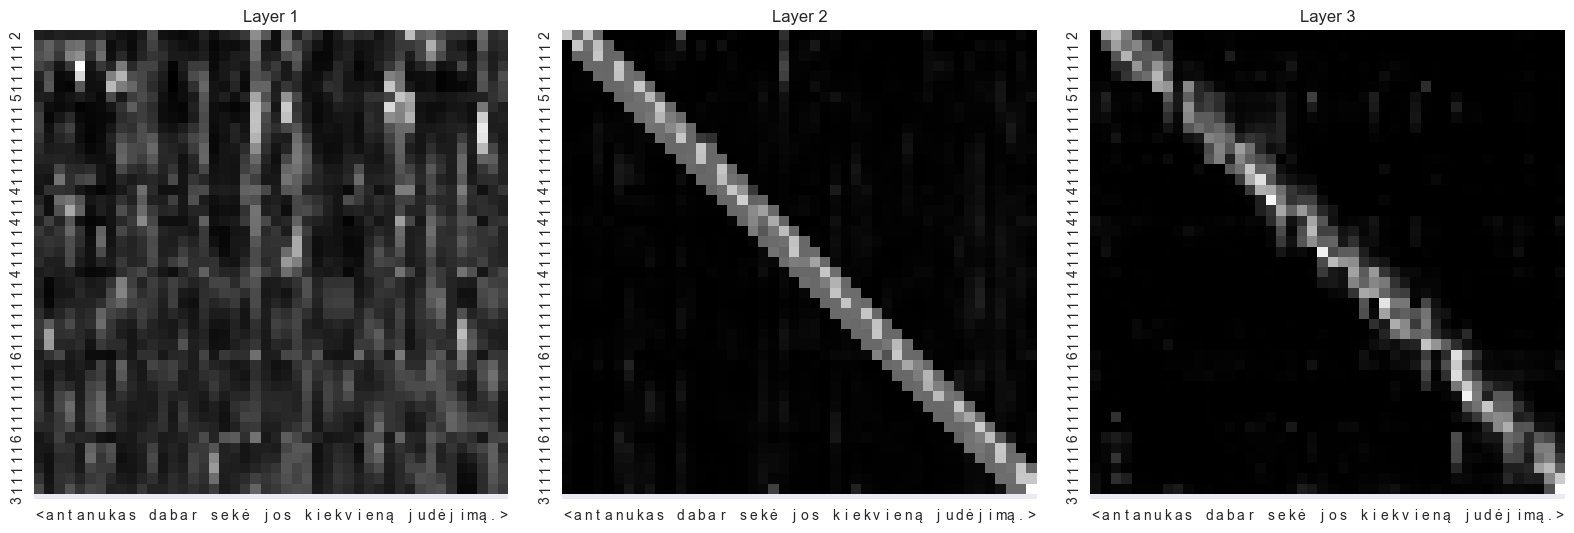

In [44]:
# Visualize averaged attention maps of each layer

fig, axs = plt.subplots(1, module.num_layers, figsize=(16, 8))
fig.tight_layout()

for layer_idx in range(module.num_layers):
    averaged_layer_weights = output_buffers[layer_idx].outputs[FINAL_INFERENCE_STEP].mean(dim=0)
    attention_map = averaged_layer_weights.detach().cpu().numpy()
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
    ax = axs[layer_idx]
    seaborn.heatmap(
        attention_map,
        xticklabels=x_labels,
        yticklabels=y_labels,
        square=True,
        vmin=0.0, vmax=1.0,
        cbar=False,
        ax=ax,
        cmap="Greys_r"
    )
    ax.set_title(f"Layer {layer_idx + 1}")
    ax.grid(False)

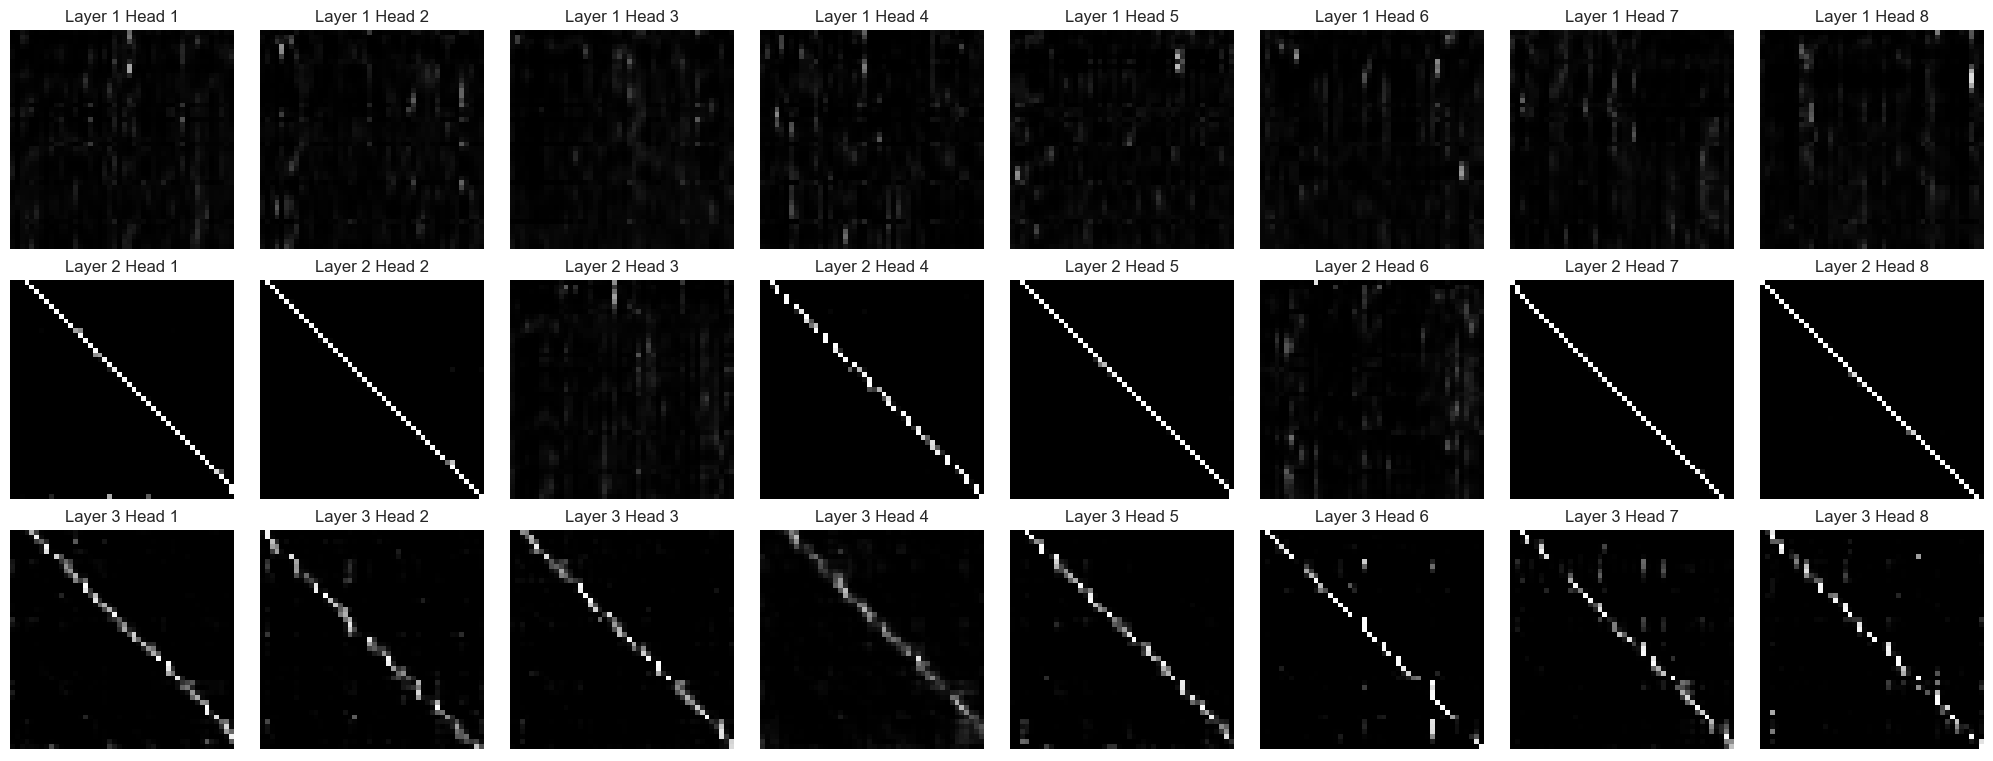

In [46]:
# Visualize attention maps of every head in each layer

fig, axs = plt.subplots(
    module.num_layers,
    inference.model.transformer.nhead,
    figsize=(inference.model.transformer.nhead * 2.5, module.num_layers * 2.5),
    constrained_layout=True
)

for layer_idx in range(module.num_layers):
    layer_weights = output_buffers[layer_idx].outputs[FINAL_INFERENCE_STEP]

    for head_idx in range(inference.model.transformer.nhead):
        head_weights = layer_weights[head_idx]
        attention_map = head_weights.detach().cpu().numpy()
        ax = axs[layer_idx][head_idx]
        seaborn.heatmap(
            attention_map,
            xticklabels=x_labels,
            yticklabels=y_labels,
            square=True,
            vmin=0.0, vmax=1.0,
            cbar=False,
            ax=ax,
            cmap="Greys_r"
        )
        ax.set_title(f"Layer {layer_idx + 1} Head {head_idx + 1}")
        ax.grid(False)
        ax.axis("off")